In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [1]:
!pip install tensorflow-addons


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_addons as tfa
import glob, warnings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

warnings.filterwarnings('ignore')
print('TensorFlow Version ' + tf.__version__)

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


TensorFlow Version 2.15.0


In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Model

def generate_classification_report(model, data_generator):
    label_dict = {
    46:"Peridinium",
    53:"Straustrum",
    43:"Ceratrium",
    9:"Cyclotella",
    12:"Microcystis",
    25:"Pedastrium",
    2:"Anabaena-coiled",
    44:"Fragillaria",
    1:"Anabaena",
    27: 'Planktothrix',
    999: 'other'
    }

    # Ensure the generator is not shuffling data
    data_generator.shuffle = False
    data_generator.reset()

    # Initialize lists to store true labels and predictions
    y_true = []
    y_pred = []

    # Collect predictions and labels
    for _ in range(len(data_generator)):
        X_batch, y_batch = next(data_generator)
        y_batch_pred = model.predict(X_batch)
        y_batch_pred = np.argmax(y_batch_pred, axis=1)
        y_batch_true = np.argmax(y_batch, axis=1)
        y_true.extend(y_batch_true)
        y_pred.extend(y_batch_pred)

    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    keys = [label_dict.get(int(values), "unknown") for values in data_generator.class_indices.keys()]
#     print(keys)
#     print([values for values in data_generator.class_indices.keys()])
    cm_df = pd.DataFrame(cm, index=keys, columns=keys)
#     print(cm_df)
    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm_df, annot=True, fmt="d", cmap="Blues")
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()

    # Calculate correct and misclassifications per class
    print("\nClass-wise Correct and Misclassified Counts:")
    for i, (index, row) in enumerate(cm_df.iterrows()):
        correct = row[index]
        misclassified = np.sum(row) - correct
        print(f"{index}: Correct = {correct}, Misclassified = {misclassified}")

    # Print classification report
    print("\nClassification Report:")
    report = classification_report(y_true, y_pred, target_names=data_generator.class_indices.keys(), zero_division=0)
    print(report)



In [4]:
!pip install --quiet vit-keras

from vit_keras import vit

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
train_dir = '/content/drive/MyDrive/top-five/train'
validation_dir = '/content/drive/MyDrive/top-five/validation'
test_dir = '/content/drive/MyDrive/top-five/test'

# Image dimensions and batch size
img_width, img_height = 224, 224  # Change depending on your requirements
batch_size = 128

# Data generators for loading images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,          # Rotate the images up to 40 degrees
    width_shift_range=0.2,      # Shift the image width by a max of 20% of the width
    height_shift_range=0.2,     # Shift the image height by a max of 20% of the height
    shear_range=0.2,            # Shear means transvection, a type of deformation
    zoom_range=0.2,             # Zoom in by 20% max
    horizontal_flip=True,       # Allow horizontal flipping
    fill_mode='nearest'         # Fill in missing pixels with the nearest filled value
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 1998 images belonging to 6 classes.
Found 129 images belonging to 6 classes.
Found 129 images belonging to 6 classes.


In [6]:
vit_model = vit.vit_b32(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 6)

In [7]:
model = tf.keras.Sequential([
        vit_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(6, 'softmax')
    ],
    name = 'vision_transformer')

model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten (Flatten)           (None, 768)               0         
                                                                 
 batch_normalization (Batch  (None, 768)               3072      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 11)                8459      
                                                                 
 batch_normalization_1 (Bat  (None, 11)                44        
 chNormalization)                                                
                                                                 
 dense_1 (Dense)             (None, 6)          

In [8]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 0.001)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

In [9]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size


In [10]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

In [11]:

history = model.fit(x = train_generator,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = validation_generator,
          validation_steps = STEP_SIZE_VALID,
          epochs = 20,
          callbacks = callbacks)


Epoch 1/20
15/15 [==============================] - ETA: 0s - loss: 1.7812 - accuracy: 0.4134
Epoch 1: val_accuracy improved from -inf to 0.71094, saving model to ./model.hdf5
15/15 [==============================] - 79s 3s/step - loss: 1.7812 - accuracy: 0.4134 - val_loss: 1.3091 - val_accuracy: 0.7109 - lr: 0.0010
Epoch 2/20
15/15 [==============================] - ETA: 0s - loss: 1.0098 - accuracy: 0.9299
Epoch 2: val_accuracy improved from 0.71094 to 0.92969, saving model to ./model.hdf5
15/15 [==============================] - 43s 3s/step - loss: 1.0098 - accuracy: 0.9299 - val_loss: 1.0801 - val_accuracy: 0.9297 - lr: 0.0010
Epoch 3/20
15/15 [==============================] - ETA: 0s - loss: 0.8949 - accuracy: 0.9674
Epoch 3: val_accuracy improved from 0.92969 to 0.97656, saving model to ./model.hdf5
15/15 [==============================] - 42s 3s/step - loss: 0.8949 - accuracy: 0.9674 - val_loss: 1.0171 - val_accuracy: 0.9766 - lr: 0.0010
Epoch 4/20
15/15 [======================

In [12]:
# Evaluate the model
test_loss, test_accuracy = model.evaluate(test_generator)

# Print results
print("Training Loss: {:.4f}, Training Accuracy: {:.2f}%".format(history.history['loss'][-1], history.history['accuracy'][-1] * 100))
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(test_loss, test_accuracy*100))

2/2 [==============================] - 1s 106ms/step - loss: 0.8741 - accuracy: 0.9690
Training Loss: 0.7974, Training Accuracy: 99.53%
Test Loss: 0.8741, Test Accuracy: 96.90%


1/1 [==============================] - 3s 3s/step


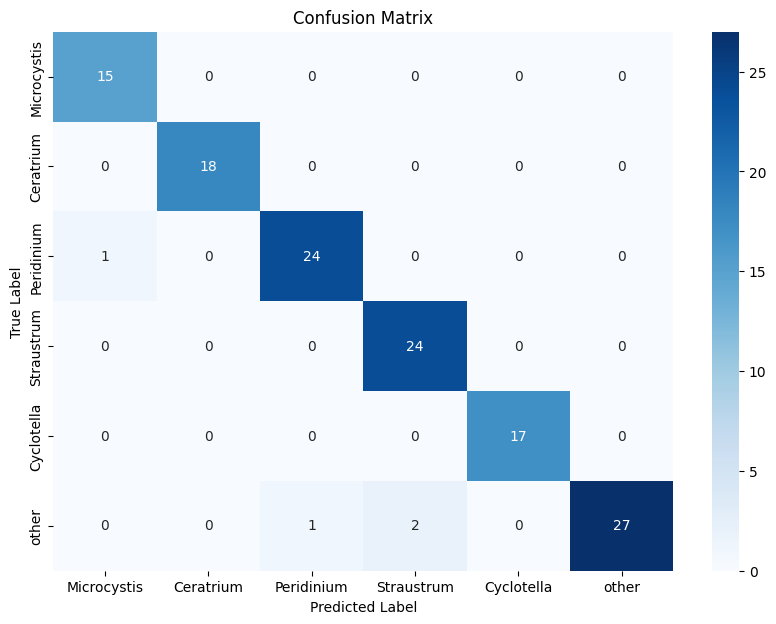


Class-wise Correct and Misclassified Counts:
Microcystis: Correct = 15, Misclassified = 0
Ceratrium: Correct = 18, Misclassified = 0
Peridinium: Correct = 24, Misclassified = 1
Straustrum: Correct = 24, Misclassified = 0
Cyclotella: Correct = 17, Misclassified = 0
other: Correct = 27, Misclassified = 3

Classification Report:
              precision    recall  f1-score   support

          12       0.94      1.00      0.97        15
          43       1.00      1.00      1.00        18
          46       0.96      0.96      0.96        25
          53       0.92      1.00      0.96        24
           9       1.00      1.00      1.00        17
         999       1.00      0.90      0.95        30

    accuracy                           0.97       129
   macro avg       0.97      0.98      0.97       129
weighted avg       0.97      0.97      0.97       129



In [13]:
generate_classification_report(model,test_generator)

In [14]:
model.save_weights('model_weights.h5')

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Directories
train_dir = '/content/drive/MyDrive/top-ten/train'
validation_dir = '/content/drive/MyDrive/top-ten/validation'
test_dir = '/content/drive/MyDrive/top-ten/test'

# Image dimensions and batch size
img_width, img_height = 224, 224  # Change depending on your requirements
batch_size = 128

# Data generators for loading images
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,          # Rotate the images up to 40 degrees
    width_shift_range=0.2,      # Shift the image width by a max of 20% of the width
    height_shift_range=0.2,     # Shift the image height by a max of 20% of the height
    shear_range=0.2,            # Shear means transvection, a type of deformation
    zoom_range=0.2,             # Zoom in by 20% max
    horizontal_flip=True,       # Allow horizontal flipping
    fill_mode='nearest'         # Fill in missing pixels with the nearest filled value
)

validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='categorical'
)


Found 3386 images belonging to 11 classes.
Found 330 images belonging to 11 classes.
Found 330 images belonging to 11 classes.


In [17]:
vit_model2 = vit.vit_b32(
        image_size = 224,
        activation = 'softmax',
        pretrained = True,
        include_top = False,
        pretrained_top = False,
        classes = 6)

In [18]:
model2 = tf.keras.Sequential([
        vit_model2,
        tf.keras.layers.Flatten(),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(50, activation = tfa.activations.gelu),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dense(11, 'softmax')
    ],
    name = 'vision_transformer')

model2.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vit-b32 (Functional)        (None, 768)               87455232  
                                                                 
 flatten_1 (Flatten)         (None, 768)               0         
                                                                 
 batch_normalization_2 (Bat  (None, 768)               3072      
 chNormalization)                                                
                                                                 
 dense_2 (Dense)             (None, 50)                38450     
                                                                 
 batch_normalization_3 (Bat  (None, 50)                200       
 chNormalization)                                                
                                                                 
 dense_3 (Dense)             (None, 11)         

In [19]:
learning_rate = 1e-4

optimizer = tfa.optimizers.RectifiedAdam(learning_rate = 0.001)

model2.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.2),
              metrics = ['accuracy'])

In [20]:
STEP_SIZE_TRAIN = train_generator.n // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.n // validation_generator.batch_size

In [21]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor = 'val_accuracy',
                                                 factor = 0.2,
                                                 patience = 2,
                                                 verbose = 1,
                                                 min_delta = 1e-4,
                                                 min_lr = 1e-6,
                                                 mode = 'max')

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_accuracy',
                                                 min_delta = 1e-4,
                                                 patience = 5,
                                                 mode = 'max',
                                                 restore_best_weights = True,
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

callbacks = [earlystopping, reduce_lr, checkpointer]

In [22]:
history2 = model2.fit(x = train_generator,
          steps_per_epoch = STEP_SIZE_TRAIN,
          validation_data = validation_generator,
          validation_steps = STEP_SIZE_VALID,
          epochs = 20,
          callbacks = callbacks)


Epoch 1/20
26/26 [==============================] - ETA: 0s - loss: 1.9702 - accuracy: 0.5427 
Epoch 1: val_accuracy improved from -inf to 0.83984, saving model to ./model.hdf5
26/26 [==============================] - 1156s 43s/step - loss: 1.9702 - accuracy: 0.5427 - val_loss: 1.4239 - val_accuracy: 0.8398 - lr: 0.0010
Epoch 2/20
26/26 [==============================] - ETA: 0s - loss: 1.1052 - accuracy: 0.9417
Epoch 2: val_accuracy improved from 0.83984 to 0.95703, saving model to ./model.hdf5
26/26 [==============================] - 71s 3s/step - loss: 1.1052 - accuracy: 0.9417 - val_loss: 1.1568 - val_accuracy: 0.9570 - lr: 0.0010
Epoch 3/20
26/26 [==============================] - ETA: 0s - loss: 1.0041 - accuracy: 0.9739
Epoch 3: val_accuracy improved from 0.95703 to 0.98047, saving model to ./model.hdf5
26/26 [==============================] - 70s 3s/step - loss: 1.0041 - accuracy: 0.9739 - val_loss: 1.0635 - val_accuracy: 0.9805 - lr: 0.0010
Epoch 4/20
26/26 [==================

In [23]:
# Evaluate the model
test_loss, test_accuracy = model2.evaluate(test_generator)

# Print results
print("Training Loss: {:.4f}, Training Accuracy: {:.2f}%".format(history2.history['loss'][-1], history2.history['accuracy'][-1] * 100))
print("Test Loss: {:.4f}, Test Accuracy: {:.2f}%".format(test_loss, test_accuracy*100))

3/3 [==============================] - 69s 34s/step - loss: 0.9834 - accuracy: 0.9697
Training Loss: 0.9241, Training Accuracy: 99.72%
Test Loss: 0.9834, Test Accuracy: 96.97%


3/3 [==============================] - 4s 132ms/step


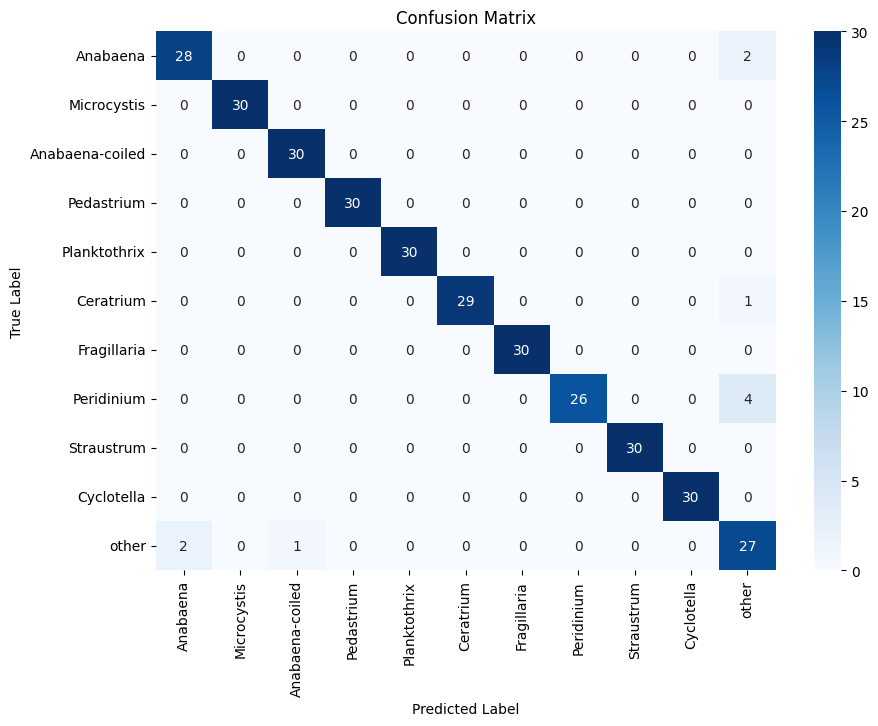


Class-wise Correct and Misclassified Counts:
Anabaena: Correct = 28, Misclassified = 2
Microcystis: Correct = 30, Misclassified = 0
Anabaena-coiled: Correct = 30, Misclassified = 0
Pedastrium: Correct = 30, Misclassified = 0
Planktothrix: Correct = 30, Misclassified = 0
Ceratrium: Correct = 29, Misclassified = 1
Fragillaria: Correct = 30, Misclassified = 0
Peridinium: Correct = 26, Misclassified = 4
Straustrum: Correct = 30, Misclassified = 0
Cyclotella: Correct = 30, Misclassified = 0
other: Correct = 27, Misclassified = 3

Classification Report:
              precision    recall  f1-score   support

           1       0.93      0.93      0.93        30
          12       1.00      1.00      1.00        30
           2       0.97      1.00      0.98        30
          25       1.00      1.00      1.00        30
          27       1.00      1.00      1.00        30
          43       1.00      0.97      0.98        30
          44       1.00      1.00      1.00        30
          46

In [24]:
generate_classification_report(model2,test_generator)

In [25]:
model2.save_weights('model2_weights.h5')